In [2]:
# Why import and not using?
# import OpenCL
# const cl = OpenCL
using OpenCL

In [7]:
using PyPlot

## Julia implementation

In [8]:
w = 2048 * 2;
h = 2048 * 2;
@printf("Size %i MB\n", sizeof(Complex64) * w * h / 1024 / 1024)

Size 128 MB


In [9]:
# julia set
# (the familiar mandelbrot set is obtained by setting c==z initially)
function julia(z; maxiter=200)
    c = Complex64(-0.5, 0.75)
    for n = 1:maxiter
        if abs2(z) > 4.0
            return n-1
        end
        z = z*z + c
    end
    return maxiter
end

julia (generic function with 1 method)

In [10]:
q = [Complex64(r,i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5];

In [11]:
function ordinary_julia(q)
    (h, w) = size(q)
    m  = Array(UInt8, (h, w));
    for i in 1:w
        for j in 1:h
            @inbounds v = q[j, i]
            @inbounds m[j, i] = julia(v)
        end
    end
    return m
end

ordinary_julia (generic function with 1 method)

In [12]:
@time m = ordinary_julia(q);

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{UInt8}, ::Tuple{Int64,Int64}) at ./deprecated.jl:57
 [3] ordinary_julia(::Array{Complex{Float32},2}) at ./In[11]:3
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/davidbuchacaprats/.julia/v0.6/IJulia/src/execute_request.jl:158
 [6] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Users/davidbuchacaprats/.julia/v0.6/Compat/src/Compat.jl:385
 [7] eventloop(::ZMQ.Socket) at /Users/davidbuchacaprats/.julia/v0.6/IJulia/src/eventloop.jl:8
 [8] (::IJulia.##14#17)() at ./task.jl:335
while loading In[12], in expression starting on line 237


  1.895964 seconds (17.10 M allocations: 289.316 MiB, 12.84% gc time)


In [13]:
get_cmap("RdGy")

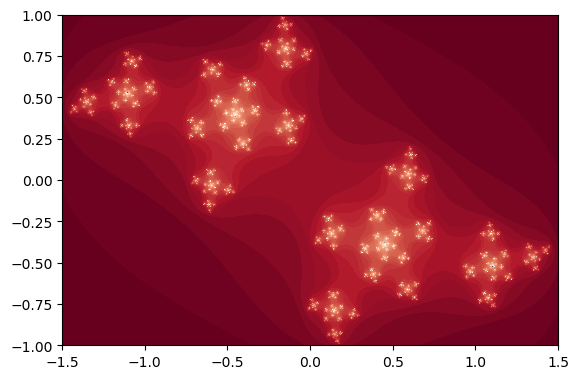

PyObject <matplotlib.image.AxesImage object at 0x141418ed0>

In [14]:
imshow(m, cmap="RdGy", extent=[-1.5,1.5,-1,1])

## OpenCL Implementation

In [17]:
cl.devices()

3-element Array{OpenCL.cl.Device,1}:
 OpenCL.Device(Intel(R) Core(TM) i7-3720QM CPU @ 2.60GHz on Apple @0x00000000ffffffff)
 OpenCL.Device(HD Graphics 4000 on Apple @0x0000000001024400)                         
 OpenCL.Device(GeForce GT 650M on Apple @0x0000000001022700)                          

## OpenCL Implementation

In [ ]:
julia_source = "
#pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
__kernel void julia(__global float2 *q,
                    __global ushort *output, 
                    ushort const maxiter)
{
 int gid = get_global_id(0);
 float nreal = 0;
 float real  = q[gid].x;
 float imag  = q[gid].y;
 
 output[gid] = 0;
 
 for(int curiter = 0; curiter < maxiter; curiter++) {
     if (real*real + imag*imag > 4.0f) {
         output[gid] = curiter;
     }
     nreal = real*real - imag*imag + -0.5f;
     imag  = 2*real*imag + 0.75f;
     real = nreal;
  }
}";

In [ ]:
function julia_opencl(q::Array{Complex64}, maxiter::Int64)
    ctx   = cl.Context(cl.devices()[4])
    queue = cl.CmdQueue(ctx)

    out = Array(UInt16, size(q))

    q_buff = cl.Buffer(Complex64, ctx, (:r, :copy), hostbuf=q)
    o_buff = cl.Buffer(UInt16, ctx, :w, length(out))

    prg = cl.Program(ctx, source=julia_source) |> cl.build!
    k = cl.Kernel(prg, "julia")
    
    cl.call(queue, k, length(q), nothing, q_buff, o_buff, uint16(maxiter))
    cl.copy!(queue, out, o_buff)
    
    return out
end

In [ ]:
#@time m = julia_opencl(q, 200);